In [ ]:
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
path = "C:\Projects_by_month\MLproject\data\ISW_csv\isw_articles.csv"

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\illya\AppData\Local\Temp\ipykernel_15380\1318559359.py:1: SyntaxWarning: invalid escape sequence '\P'
  path = "C:\Projects_by_month\MLproject\data\ISW_csv\isw_articles.csv"


In [13]:
data = pd.read_csv(path)

In [18]:
data.head(5), data.columns

(   id                                              title        date  \
 0   2  Russian Offensive Campaign Assessment, March 2...  2025-03-23   
 1   3  Russian Offensive Campaign Assessment, March 2...  2025-03-22   
 2   4  Russian Offensive Campaign Assessment, March 2...  2025-03-21   
 3   5  Russian Offensive Campaign Assessment, March 2...  2025-03-20   
 4   6  Russian Offensive Campaign Assessment, March 1...  2025-03-19   
 
                                              summary  
 0  US and Ukrainian officials are meeting in Riya...  
 1  US Special Envoy to the Middle East Steve Witk...  
 2  The Kremlin is weaponizing ongoing ceasefire n...  
 3  Ukrainian forces conducted a drone strike agai...  
 4  Russia and Ukraine have not formally announced...  ,
 Index(['id', 'title', 'date', 'summary'], dtype='object'))

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\illya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\illya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

[('russian', 4267), ('ukrainian', 2709), ('forces', 2422), ('ukraine', 1500), ('russia', 916), ('oblast', 829), ('military', 800), ('have', 700), ('from', 670), ('likely', 652)]


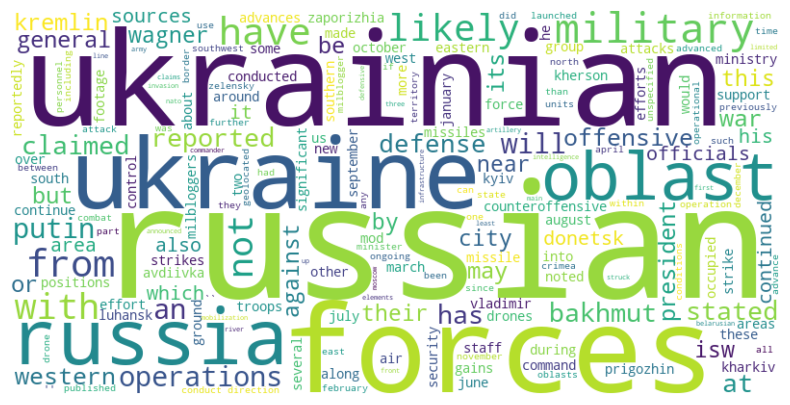

In [ ]:

all_text = " ".join(data["summary"])

words = word_tokenize(all_text.lower())

stop_words = set(stopwords.words('english') + 
                 stopwords.words('russian') + 
                 stopwords.words('ukrainian') if 'ukrainian' in stopwords._fileids else [])

custom_stopwords = ['the', 'of', 'and', 'to', 'in', 'that', 'on', 'a', 'for', 'are', 'is', 'as',
                    '.', ',', ':', ';', ')', '(', "'", '"', "'s"]
stop_words.update(custom_stopwords)

filtered_words = [word for word in words if word not in stop_words and len(word) > 1]

word_freq = Counter(filtered_words)

print(word_freq.most_common(10))

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

C:\Users\illya\AppData\Local\Temp\ipykernel_15380\2441384825.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=counts, y=words, palette='viridis')


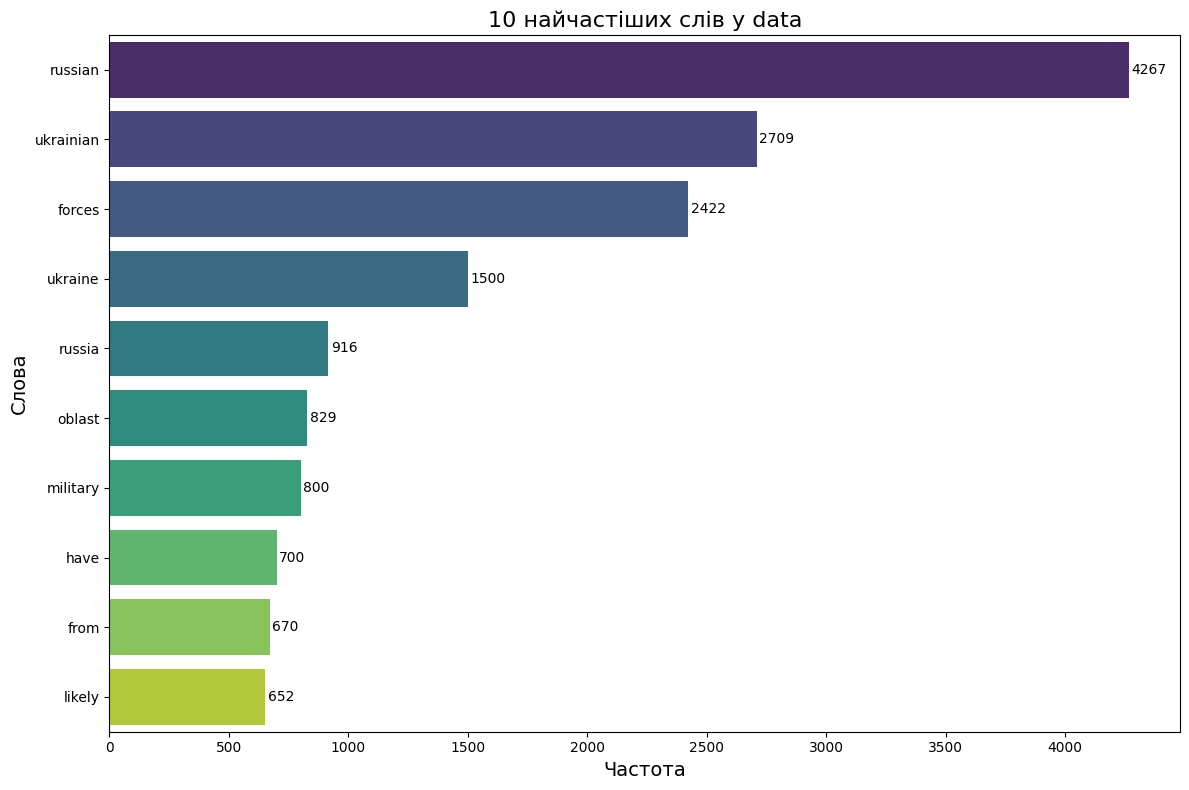

In [43]:
top_words = word_freq.most_common(10)
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 8))
bars = sns.barplot(x=counts, y=words, palette='viridis')

for i, v in enumerate(counts):
    plt.text(v + 10, i, str(v), va='center')

plt.title('10 найчастіших слів у data', fontsize=16)
plt.xlabel('Частота', fontsize=14)
plt.ylabel('Слова', fontsize=14)
plt.tight_layout()


**Поки з цих слів важко отримати конкретну користь, df потребує додаткової обробки.**

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(data["summary"])

feature_names = vectorizer.get_feature_names_out()
mean_tfidf = tfidf_matrix.mean(axis=0).A1
top_words = sorted(zip(feature_names, mean_tfidf), key=lambda x: x[1], reverse=True)[:10]

print("Топ-10 найбільш значущих слів за TF-IDF:")
for word, score in top_words:
    print(f"{word}: {score:.4f}")


Топ-10 найбільш значущих слів за TF-IDF:
russian: 0.1110
ukrainian: 0.0872
forces: 0.0774
ukraine: 0.0613
russia: 0.0454
oblast: 0.0385
military: 0.0352
putin: 0.0348
operations: 0.0291
war: 0.0290


In [49]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data["cluster"] = kmeans.fit_predict(tfidf_matrix)

print(data[["title", "cluster"]])

                                                  title  cluster
0     Russian Offensive Campaign Assessment, March 2...        3
1     Russian Offensive Campaign Assessment, March 2...        2
2     Russian Offensive Campaign Assessment, March 2...        2
3     Russian Offensive Campaign Assessment, March 2...        4
4     Russian Offensive Campaign Assessment, March 1...        2
...                                                 ...      ...
1134  Russia-Ukraine Warning Update: Russian Offensi...        4
1135  Turkey Juggles Relationships after Russia’s In...        2
1136                          Ukraine Conflict Update 8        4
1137  Russia-Ukraine Warning Update: Russian Offensi...        4
1138  Russia-Ukraine Warning Update: Initial Russian...        2

[1139 rows x 2 columns]


<Axes: title={'center': 'Кількість звітів по тижнях'}, xlabel='date'>

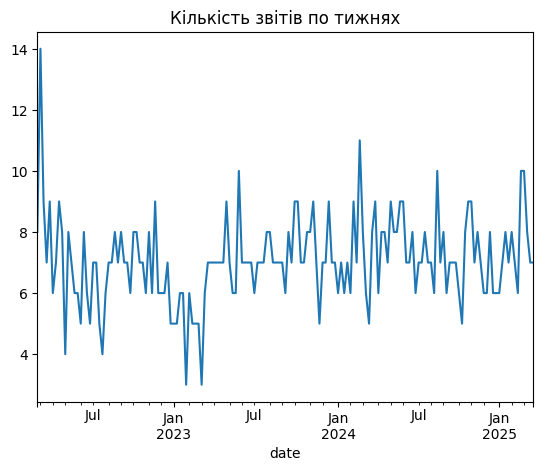

In [55]:
data["date"] = pd.to_datetime(data["date"])
data.set_index("date").resample("W")["summary"].count().plot(title="Кількість звітів по тижнях")